In [61]:
import pyvista as pv
import matplotlib.pyplot as plt
import numpy as np

=== Curvature Information ===
Max curvature index: 17, value = 0.595592
Start index: 9, curvature = 0.254943
End index: 23, curvature = 0.286354
Threshold (max × 0.5) = 0.297796
Segment point count: 15


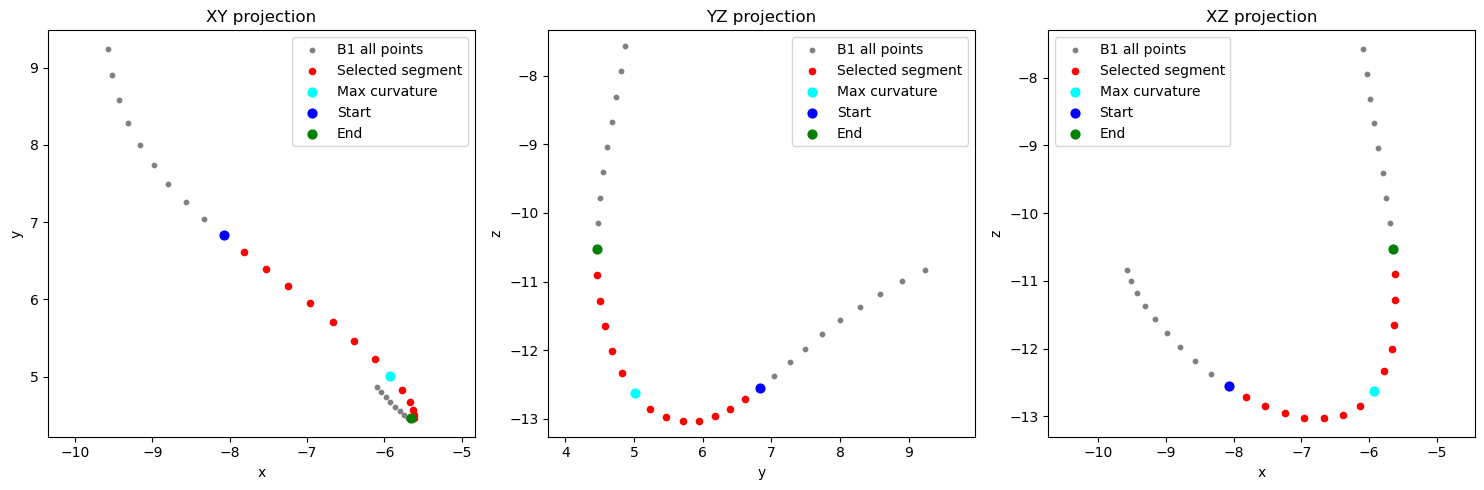

In [62]:
# === Parameters ===
DROP_RATIO = 0.5

# === Load data ===
input_path = r"D:\github\Phd_summary\1_Data\1_Brava\1_Centerline\8_Centerline_Siphon(with labal)\BG0001_L_siphon_lab.vtk"
centerline = pv.read(input_path)

points = centerline.points
labels = centerline["lab"]
curvature = centerline["curvature"]

# === Extract B1 region ===
bend1_pts = points[labels == 1]
bend1_curv = curvature[labels == 1]

# === Adaptive segment extraction ===
def extract_adaptive_segment(pts, curv, drop_ratio=DROP_RATIO):
    max_idx = np.argmax(curv)
    max_val = curv[max_idx]
    left_idx, right_idx = max_idx, max_idx
    while left_idx > 0 and curv[left_idx] > drop_ratio * max_val:
        left_idx -= 1
    while right_idx < len(curv) - 1 and curv[right_idx] > drop_ratio * max_val:
        right_idx += 1
    seg_pts = pts[left_idx:right_idx+1]
    return seg_pts, max_idx, left_idx, right_idx, max_val

seg_pts, max_idx, left_idx, right_idx, max_val = extract_adaptive_segment(bend1_pts, bend1_curv)

# === Curvature information ===
curv_max = bend1_curv[max_idx]
curv_start = bend1_curv[left_idx]
curv_end = bend1_curv[right_idx]
threshold = DROP_RATIO * curv_max

print("=== Curvature Information ===")
print(f"Max curvature index: {max_idx}, value = {curv_max:.6f}")
print(f"Start index: {left_idx}, curvature = {curv_start:.6f}")
print(f"End index: {right_idx}, curvature = {curv_end:.6f}")
print(f"Threshold (max × {DROP_RATIO}) = {threshold:.6f}")
#print(f"Start / Threshold ratio = {curv_start / threshold:.3f}")
#print(f"End / Threshold ratio   = {curv_end / threshold:.3f}")
print(f"Segment point count: {len(seg_pts)}")

# === Plot XY / YZ / XZ projections ===
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
titles = ["XY projection", "YZ projection", "XZ projection"]
coords = [(0, 1), (1, 2), (0, 2)]

for ax, (i, j), title in zip(axes, coords, titles):
    ax.scatter(bend1_pts[:, i], bend1_pts[:, j], s=10, color="gray", label="B1 all points")
    ax.scatter(seg_pts[:, i], seg_pts[:, j], s=20, color="red", label="Selected segment")
    ax.scatter(bend1_pts[max_idx, i], bend1_pts[max_idx, j], s=40, color="cyan", label="Max curvature")
    ax.scatter(bend1_pts[left_idx, i], bend1_pts[left_idx, j], s=40, color="blue", label="Start")
    ax.scatter(bend1_pts[right_idx, i], bend1_pts[right_idx, j], s=40, color="green", label="End")
    ax.set_xlabel(["x", "y", "z"][i])
    ax.set_ylabel(["x", "y", "z"][j])
    ax.set_title(title)
    ax.legend()
    ax.axis("equal")

plt.tight_layout()
plt.show()


=== Curvature Information ===
Max curvature index: 17, value = 0.595592
Start index: 9, curvature = 0.254943
End index: 23, curvature = 0.286354
Threshold (max × 0.5) = 0.297796
Segment point count: 15


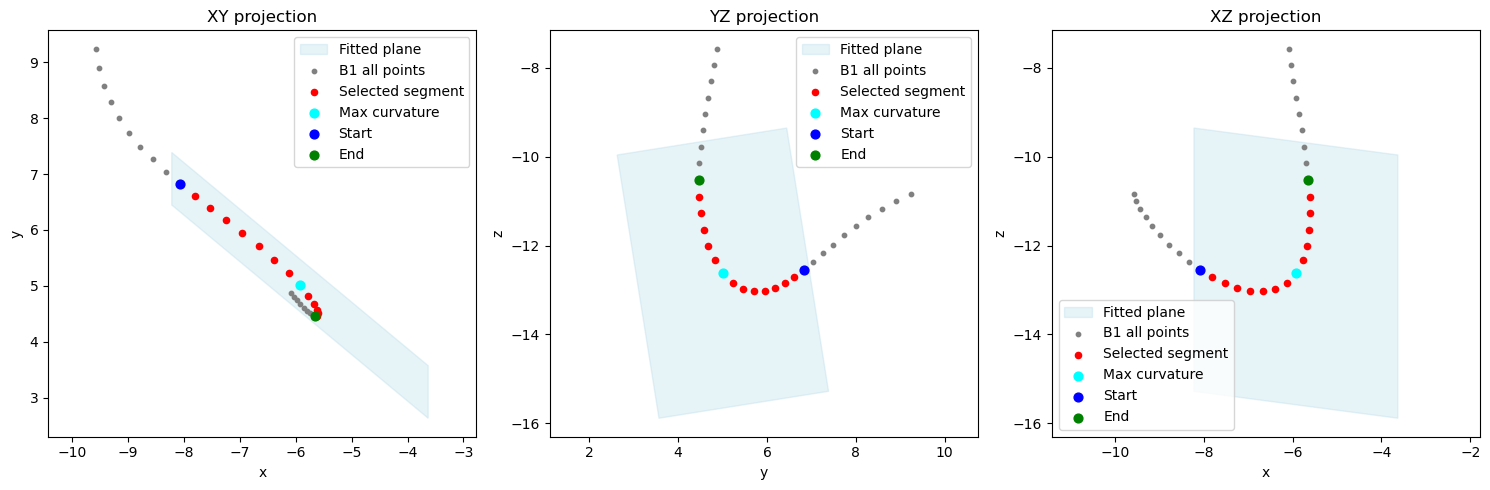

In [63]:
# === Parameters ===
DROP_RATIO = 0.5
PLANE_SIZE = 3  # 平面显示尺寸

# === Load data ===
input_path = r"D:\github\Phd_summary\1_Data\1_Brava\1_Centerline\8_Centerline_Siphon(with labal)\BG0001_L_siphon_lab.vtk"
centerline = pv.read(input_path)

points = centerline.points
labels = centerline["lab"]
curvature = centerline["curvature"]

# === Extract B1 region ===
bend1_pts = points[labels == 1]
bend1_curv = curvature[labels == 1]

# === Adaptive segment extraction ===
def extract_adaptive_segment(pts, curv, drop_ratio=DROP_RATIO):
    max_idx = np.argmax(curv)
    max_val = curv[max_idx]
    left_idx, right_idx = max_idx, max_idx
    while left_idx > 0 and curv[left_idx] > drop_ratio * max_val:
        left_idx -= 1
    while right_idx < len(curv) - 1 and curv[right_idx] > drop_ratio * max_val:
        right_idx += 1
    seg_pts = pts[left_idx:right_idx+1]
    return seg_pts, max_idx, left_idx, right_idx, max_val

seg_pts, max_idx, left_idx, right_idx, max_val = extract_adaptive_segment(bend1_pts, bend1_curv)

# === Curvature information ===
curv_max = bend1_curv[max_idx]
curv_start = bend1_curv[left_idx]
curv_end = bend1_curv[right_idx]
threshold = DROP_RATIO * curv_max

print("=== Curvature Information ===")
print(f"Max curvature index: {max_idx}, value = {curv_max:.6f}")
print(f"Start index: {left_idx}, curvature = {curv_start:.6f}")
print(f"End index: {right_idx}, curvature = {curv_end:.6f}")
print(f"Threshold (max × {DROP_RATIO}) = {threshold:.6f}")
print(f"Segment point count: {len(seg_pts)}")

# === Fit plane according to Eq.(10–16) ===
p_max = bend1_pts[max_idx]
mean_pt = np.mean(seg_pts, axis=0)
centered = seg_pts - mean_pt

cov = np.dot(centered.T, centered)
eigvals, eigvecs = np.linalg.eigh(cov)
n = eigvecs[:, np.argmin(eigvals)]
n = n / np.linalg.norm(n)

# === Generate rectangular plane (centered at p_max, normal=n)
temp = np.array([1, 0, 0]) if abs(n[0]) < 0.9 else np.array([0, 1, 0])
u = np.cross(n, temp)
u /= np.linalg.norm(u)
v = np.cross(n, u)

plane_corners = np.array([
    p_max + PLANE_SIZE * ( u + v),
    p_max + PLANE_SIZE * (-u + v),
    p_max + PLANE_SIZE * (-u - v),
    p_max + PLANE_SIZE * ( u - v)
])

# === Plot XY / YZ / XZ projections ===
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
titles = ["XY projection", "YZ projection", "XZ projection"]
coords = [(0, 1), (1, 2), (0, 2)]

for ax, (i, j), title in zip(axes, coords, titles):
    # 平面绘制
    plane_x = plane_corners[:, i]
    plane_y = plane_corners[:, j]
    ax.fill(plane_x, plane_y, color="lightblue", alpha=0.3, label="Fitted plane")

    # 点分布
    ax.scatter(bend1_pts[:, i], bend1_pts[:, j], s=10, color="gray", label="B1 all points")
    ax.scatter(seg_pts[:, i], seg_pts[:, j], s=20, color="red", label="Selected segment")
    ax.scatter(bend1_pts[max_idx, i], bend1_pts[max_idx, j], s=40, color="cyan", label="Max curvature")
    ax.scatter(bend1_pts[left_idx, i], bend1_pts[left_idx, j], s=40, color="blue", label="Start")
    ax.scatter(bend1_pts[right_idx, i], bend1_pts[right_idx, j], s=40, color="green", label="End")

    ax.set_xlabel(["x", "y", "z"][i])
    ax.set_ylabel(["x", "y", "z"][j])
    ax.set_title(title)
    ax.legend()
    ax.axis("equal")

plt.tight_layout()
plt.show()


In [64]:
# === Parameters ===
DROP_RATIO = 0.5
PLANE_SIZE = 3.5
ARROW_SCALE = 2.0
SPHERE_RADIUS = 0.2

# === Load data ===
input_path = r"D:\github\Phd_summary\1_Data\1_Brava\1_Centerline\8_Centerline_Siphon(with labal)\BG0001_L_siphon_lab.vtk"
centerline = pv.read(input_path)

points = centerline.points
labels = centerline["lab"]
curvature = centerline["curvature"]

# === Extract B1 region ===
bend1_pts = points[labels == 1]
bend1_curv = curvature[labels == 1]

# === Step 1: Select fitting segment ===
def extract_adaptive_segment(pts, curv, drop_ratio=DROP_RATIO):
    max_idx = np.argmax(curv)
    max_val = curv[max_idx]
    left_idx, right_idx = max_idx, max_idx
    while left_idx > 0 and curv[left_idx] > drop_ratio * max_val:
        left_idx -= 1
    while right_idx < len(curv) - 1 and curv[right_idx] > drop_ratio * max_val:
        right_idx += 1
    seg_pts = pts[left_idx:right_idx+1]
    return seg_pts, max_idx, left_idx, right_idx, max_val

seg_pts, max_idx, left_idx, right_idx, max_val = extract_adaptive_segment(bend1_pts, bend1_curv)

# === Step 2: Fit plane (Eq.10–16) ===
p_max = bend1_pts[max_idx]           # 平面过最大曲率点
mean_pt = np.mean(seg_pts, axis=0)
centered = seg_pts - mean_pt

cov = np.dot(centered.T, centered)
eigvals, eigvecs = np.linalg.eigh(cov)
n = eigvecs[:, np.argmin(eigvals)]
n = n / np.linalg.norm(n)

# === Step 3: Build rectangular plane ===
temp = np.array([1, 0, 0]) if abs(n[0]) < 0.9 else np.array([0, 1, 0])
u = np.cross(n, temp)
u /= np.linalg.norm(u)
v = np.cross(n, u)

plane_corners = np.array([
    p_max + PLANE_SIZE * ( u + v),
    p_max + PLANE_SIZE * (-u + v),
    p_max + PLANE_SIZE * (-u - v),
    p_max + PLANE_SIZE * ( u - v)
])
faces = [4, 0, 1, 2, 3]
plane_mesh = pv.PolyData(plane_corners, faces)

# === Step 4: Build visualization objects ===
arrow = pv.Arrow(start=p_max, direction=n, scale=ARROW_SCALE)
max_point = pv.Sphere(radius=SPHERE_RADIUS, center=p_max)

# === Step 5: Interactive rendering ===
pl = pv.Plotter(notebook=False)
pl.add_mesh(centerline, color="black", line_width=2, label="Centerline")
pl.add_points(bend1_pts, color="gray", point_size=8, label="B1 points")
pl.add_points(seg_pts, color="red", point_size=10, label="Selected segment")
pl.add_mesh(plane_mesh, color="lightblue", opacity=0.4, label="Fitted plane")
pl.add_mesh(max_point, color="cyan", label="Max curvature point")
pl.add_mesh(arrow, color="navy", label="Plane normal vector")

# 标记起点与终点
pl.add_mesh(pv.Sphere(radius=SPHERE_RADIUS, center=bend1_pts[left_idx]), color="blue", label="Start")
pl.add_mesh(pv.Sphere(radius=SPHERE_RADIUS, center=bend1_pts[right_idx]), color="green", label="End")

pl.add_legend()
pl.show()


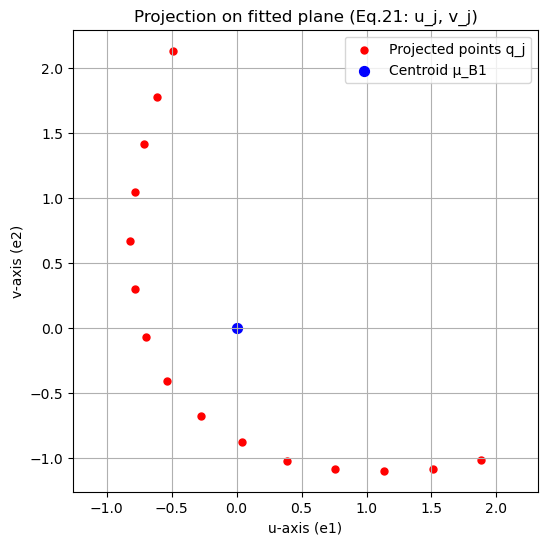

In [24]:
import pyvista as pv
import matplotlib.pyplot as plt
import numpy as np

# === Parameters ===
DROP_RATIO = 0.5

# === Load data ===
input_path = r"D:\github\Phd_summary\1_Data\1_Brava\1_Centerline\8_Centerline_Siphon(with labal)\BG0001_L_siphon_lab.vtk"
centerline = pv.read(input_path)

points = centerline.points
labels = centerline["lab"]
curvature = centerline["curvature"]

# === Extract B1 region ===
bend1_pts = points[labels == 1]
bend1_curv = curvature[labels == 1]

# === Step 1: Select fitting segment ===
def extract_adaptive_segment(pts, curv, drop_ratio=DROP_RATIO):
    max_idx = np.argmax(curv)
    max_val = curv[max_idx]
    left_idx, right_idx = max_idx, max_idx
    while left_idx > 0 and curv[left_idx] > drop_ratio * max_val:
        left_idx -= 1
    while right_idx < len(curv) - 1 and curv[right_idx] > drop_ratio * max_val:
        right_idx += 1
    seg_pts = pts[left_idx:right_idx+1]
    return seg_pts, max_idx, left_idx, right_idx, max_val

seg_pts, max_idx, left_idx, right_idx, max_val = extract_adaptive_segment(bend1_pts, bend1_curv)

# === Step 2: Fit plane (Eq.10–16) ===
mean_pt = np.mean(seg_pts, axis=0)
centered = seg_pts - mean_pt
cov = np.dot(centered.T, centered)
eigvals, eigvecs = np.linalg.eigh(cov)
n_B1 = eigvecs[:, np.argmin(eigvals)] / np.linalg.norm(eigvecs[:, np.argmin(eigvals)])

# === Step 3: Project points onto plane (Eq.17–19) ===
proj_points_3d = []
for p in seg_pts:
    v_j = p - mean_pt
    q_j = p - np.dot(v_j, n_B1) * n_B1
    proj_points_3d.append(q_j)
proj_points_3d = np.array(proj_points_3d)

# === Step 4: Define local coordinate system {e1, e2} (Eq.20) ===
temp = np.array([1, 0, 0]) if abs(n_B1[0]) < 0.9 else np.array([0, 1, 0])
e1 = np.cross(n_B1, temp); e1 /= np.linalg.norm(e1)
e2 = np.cross(n_B1, e1); e2 /= np.linalg.norm(e2)

# === Step 5: Compute 2D coordinates (Eq.21) ===
u_v_coords = np.array([[np.dot(q - mean_pt, e1), np.dot(q - mean_pt, e2)] for q in proj_points_3d])

# === Step 6: 2D visualization only ===
plt.figure(figsize=(6, 6))
plt.scatter(u_v_coords[:, 0], u_v_coords[:, 1], s=25, color="red", label="Projected points q_j")
plt.scatter(0, 0, s=50, color="blue", label="Centroid μ_B1")
plt.title("Projection on fitted plane (Eq.21: u_j, v_j)")
plt.xlabel("u-axis (e1)")
plt.ylabel("v-axis (e2)")
plt.legend()
plt.axis("equal")
plt.grid(True)
plt.show()


=== Circle Fitting Comparison ===
[Algebraic] Center = (1.083459, 0.807938), Radius = 1.958332
[Refined ] Center = (1.092327, 0.812855), Radius = 1.964686
Number of points: 15



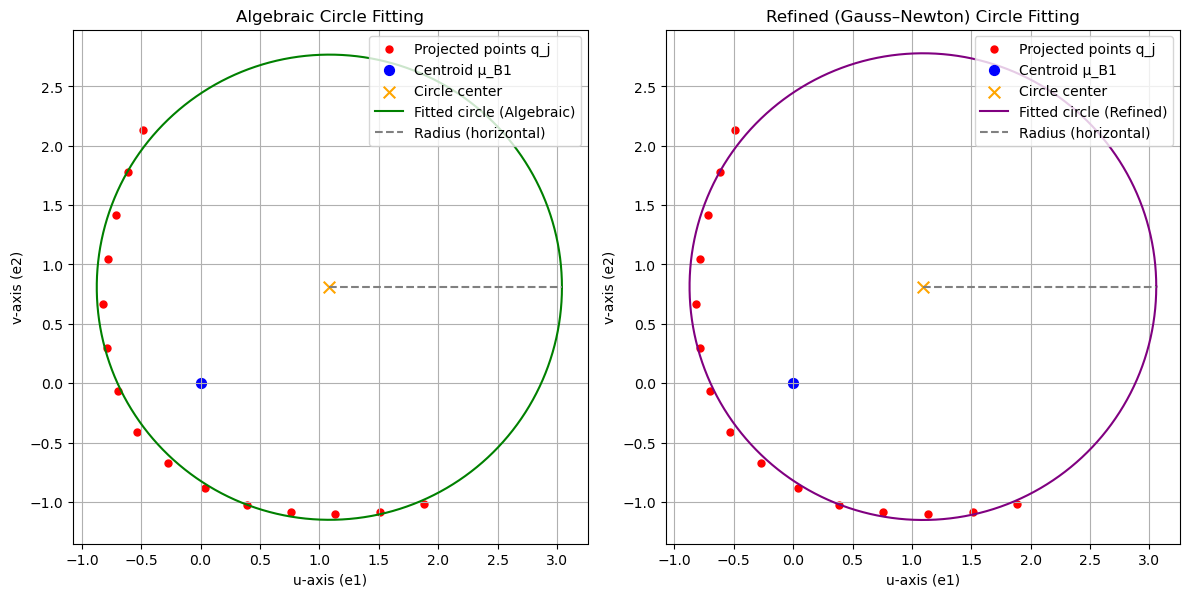

In [60]:
import numpy as np
import matplotlib.pyplot as plt

# === Step 1. Algebraic circle fitting ===
def fit_circle_algebraic(points_2d):
    x = points_2d[:, 0]
    y = points_2d[:, 1]
    A = np.c_[x, y, np.ones_like(x)]
    b = -(x**2 + y**2)
    coeff, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
    a, b_, c = coeff
    xc = -a / 2
    yc = -b_ / 2
    r = np.sqrt((a**2 + b_**2) / 4 - c)
    return xc, yc, r


# === Step 2. Geometric refinement (Gauss–Newton) ===
def fit_circle_refine(points_2d, init_params=None, max_iter=100, tol=1e-10, lam=1e-6):
    x = points_2d[:, 0].astype(float)
    y = points_2d[:, 1].astype(float)

    # --- 初期値: 使用点的重心和平均半径 ---
    if init_params is None:
        xc = np.mean(x)
        yc = np.mean(y)
        r = np.mean(np.sqrt((x - xc)**2 + (y - yc)**2))
    else:
        xc, yc, r = init_params

    last_cost = np.inf
    for _ in range(max_iter):
        Ri = np.sqrt((x - xc)**2 + (y - yc)**2)
        Ri = np.where(Ri < 1e-12, 1e-12, Ri)
        residuals = Ri - r
        J = np.c_[ -(x - xc) / Ri, -(y - yc) / Ri, -np.ones_like(Ri) ]
        H = J.T @ J + lam * np.eye(3)
        g = J.T @ residuals
        delta = -np.linalg.solve(H, g)

        xc += delta[0]
        yc += delta[1]
        r  += delta[2]

        cost = np.mean(residuals**2)
        if abs(last_cost - cost) < tol or np.linalg.norm(delta) < tol:
            break
        last_cost = cost

    return xc, yc, r


# === Run both methods ===
xc_alg, yc_alg, r_alg = fit_circle_algebraic(u_v_coords)
xc_ref, yc_ref, r_ref = fit_circle_refine(u_v_coords)  # ← 用重心初始化

print("=== Circle Fitting Comparison ===")
print(f"[Algebraic] Center = ({xc_alg:.6f}, {yc_alg:.6f}), Radius = {r_alg:.6f}")
print(f"[Refined ] Center = ({xc_ref:.6f}, {yc_ref:.6f}), Radius = {r_ref:.6f}")
print(f"Number of points: {len(u_v_coords)}\n")


# === Visualization (1x2 subplot, fixed axis limits) ===
theta = np.linspace(0, 2*np.pi, 200)
circle_alg_u = xc_alg + r_alg * np.cos(theta)
circle_alg_v = yc_alg + r_alg * np.sin(theta)
circle_ref_u = xc_ref + r_ref * np.cos(theta)
circle_ref_v = yc_ref + r_ref * np.sin(theta)

# 统一坐标范围
all_x = np.concatenate([u_v_coords[:, 0], circle_alg_u, circle_ref_u])
all_y = np.concatenate([u_v_coords[:, 1], circle_alg_v, circle_ref_v])
x_min, x_max = np.min(all_x) - 0.2, np.max(all_x) + 0.2
y_min, y_max = np.min(all_y) - 0.2, np.max(all_y) + 0.2

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
titles = ["Algebraic Circle Fitting", "Refined (Gauss–Newton) Circle Fitting"]
centers = [(xc_alg, yc_alg, r_alg), (xc_ref, yc_ref, r_ref)]
circles = [(circle_alg_u, circle_alg_v), (circle_ref_u, circle_ref_v)]
colors = ["green", "purple"]

for ax, title, (xc, yc, r), (cu, cv), color in zip(axes, titles, centers, circles, colors):
    ax.scatter(u_v_coords[:, 0], u_v_coords[:, 1], s=25, color="red", label="Projected points q_j")
    ax.scatter(0, 0, s=50, color="blue", label="Centroid μ_B1")
    ax.scatter(xc, yc, s=70, color="orange", marker="x", label="Circle center")
    ax.plot(cu, cv, color=color, label=f"Fitted circle ({title.split()[0]})")
    ax.plot([xc, xc + r], [yc, yc], color="gray", linestyle="--", label="Radius (horizontal)")
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel("u-axis (e1)")
    ax.set_ylabel("v-axis (e2)")
    ax.set_title(title)
    ax.legend(loc="upper right", frameon=True)
    ax.grid(True)

plt.tight_layout()
plt.show()
